In [73]:
#export
"""A quick and dirty tiny module emulating the `p5js <https://p5js.org/>`_
environment. I made this because I have used Processing extensively in
the past, and would like a simple interface to draw stuff. Processing
doesn't really exist on Python (yes, I know of Processing's python mode,
but it's Jython, not pure python!), so I made this based upon the
`drawsvg <https://github.com/cduck/drawSvg>`_ library. Download that
before using this module. Example::

    from k1lib.imports import *

    p5.newSketch(200, 200); p5.background(150)
    p5.rect(0, 0, 60, 60)
    with p5.context(): # all style changes here will be reverted on exiting the context
        p5.fill(255, 0, 0)
        p5.rect(0, 0, 60, 50)
    p5.rect(0, 0, 30, 30)
    p5.fill(255, 180); p5.ellipse(60, 50, 20)
    p5.textSize(12); p5.text("abc", 30, 30)
    with p5.context():
        p5.fill(0, 0, 255); p5.noStroke(); p5.textSize(20)
        p5.text("def", 60, 60)
    p5.img() # get PIL image

Result:

.. image:: images/p5.png"""
import k1lib, math, numpy as np, random, base64, json; import k1lib.cli as cli; from typing import List, Iterator
from collections import defaultdict, deque
drawsvg = k1lib.dep("drawsvg", "drawsvg[all]", "https://github.com/cduck/drawSvg")
__all__ = ["color", "newSketch", "fill", "noFill", "stroke", "noStroke", "ellipse", "arc", "rect", "textSize", "text", "background", "img",
           "Entity", "Point", "point_raw", "point_rnd", "point_sym", "point_L", "triangle",
           "Line", "line_2P", "line_2PL", "Circle", "circle_PR", "circle_2P", "grid", "axes", "IR",
           "Sketch"]

In [2]:
#export
def color(r, g=None, b=None, alpha=255):
    """Get hex representation of a color.
Example::

    p5.color(255, 0, 0) # returns "#ff0000ff", red
    p5.color(255, 0, 0, 100) # returns "#ff000064", transparent red
    p5.color(255, 100) # returns "#ffffff64", transparent white"""
    if isinstance(r, str):
        if g is not None or b is not None: raise Exception(f"Doesn't understand this color specification: {r}, {g}, {b}, {alpha}")
        r = "#" + r.strip("#")
        if len(r) == 7: return r + "ff"
        elif len(r) == 9: return r
        else: raise Exception(f"Doesn't understand this string color: {r}")
    if g is None and b is None: g = r; b = r
    if g is not None and b is None: alpha = g; g = r; b = r
    return f"#{r:02x}{g:02x}{b:02x}{alpha:02x}"

In [3]:
assert color(255, 0, 0) == "#ff0000ff"
assert color(255, 0, 0, 100) == "#ff000064"
assert color(255, 100) == "#ffffff64"

In [4]:
#export
c = k1lib.Settings();
context = c.context
def _strokeAlpha(): return int(c.stroke[-2:], 16) if c.stroke else 255
def _fillAlpha(): return int(c.fill[-2:], 16) if c.fill else 255
def _alpha(): return min(_strokeAlpha(), _fillAlpha())
def _cs(): return {"fill": c.fill, "stroke": c.stroke, "fill_opacity": _fillAlpha()/255, "stroke_opacity": _strokeAlpha()/255} # colors shorthand
def newSketch(w, h, flip=True, pad=0, scale=1, xoff=0, yoff=0):
    """Creates a new sketch with specified height and width.

If ``pad``, ``scale``, ``xoff`` or ``yoff`` is specified, it will pad the sketch then scale it up with
that amount. In other words, the true width (in pixels) is going to be ``w*scale + 2*pad``, true height
is ``h*scale + 2*pad``. Then, all coordinates will be ``(x-xoff)*scale + pad`` and ``(y-yoff)*scale + pad``,
and any radius/size will be ``r*scale``.

:param flip: if True (default), use mathematical coordinate (y increases from bottom of image to top), else use
    programming coordinate (y increases from top of image to bottom). This only affects the y axis,
    leaving x axis and radiuses alone
:param xoff: x offset. If specified, along side with yoff, then the sketch will have the
    point (xoff,yoff) at origin
"""
    c.d = drawsvg.Drawing(w*scale+2*pad, h*scale+2*pad); c.w = w; c.h = h
    c.stroke = color(0); c.fill = color(255); c.fontSize = 12; c.flip = flip; c.pad = pad; c.scale = scale
    c.xt = lambda x: (x-xoff)*scale+pad; c.rt = lambda r: r*scale
    if flip: c.yt = lambda y: (h-(y-yoff))*scale+pad; c.ht = lambda h: -h*scale # y transform and h transform
    else: c.yt = lambda y: (y-yoff)*scale+pad; c.ht = lambda h: h*scale
def fill(*args):
    """Sets fill color"""
    c.fill = color(*args)
def noFill():
    """Turns off fill color"""
    c.fill = color(255, 0)
def stroke(*args):
    """Sets stroke color"""
    c.stroke = color(*args)
def noStroke():
    """Turns off stroke color"""
    c.stroke = color(255, 0)
def ellipse(x, y, w):
    """Draws a circle at a particular location. Can't truly draw ellipses cause idk how"""
    c.d.append(drawsvg.Circle(c.xt(x), c.yt(y), c.rt(w/2), **_cs()))
pi = 3.141592653589793
def arc(x, y, r, startAngle, endAngle):
    """Draws an arc.

If in mathematical coordinates, will go counter clockwise from startAngle to endAngle.
If in programming coordinates, will go counter clockwise instead.

If startAngle < endAngle, and the difference between them is also pretty small (say 45deg),
then the sweep angle will also be small. If startAngle > endAngle, then the sweep angle
is going to be very big (360-45)"""
    f = (1-2*c.flip)*180/pi; c.d.append(drawsvg.Arc(c.xt(x), c.yt(y), c.rt(r), startAngle*f, endAngle*f, cw=f>0, **_cs()))
def line(x1,y1,x2,y2):
    """Draws a line from (x1, y1) to (x2, y2)"""
    c.d.append(drawsvg.Line(c.xt(x1),c.yt(y1),c.xt(x2),c.yt(y2),**_cs()))
def image(img:"PIL", x, y, w=None, h=None):
    """Draws a PIL image at a particular position.
Example::

    img = "image_file.png" | toImg()
    p5.newSketch(400, 200)
    p5.image(img, 20, 20)

You can transform it first using torchvision.transforms before drawing it like this::

    img = "image_file.png" | toImg()
    img = img | aS(tf.Resize(200)) # torchvision.transforms is imported as `tf` automatically. Check module `k1lib.imports`
"""
    s = img | cli.shape(); c.d.append(drawsvg.Image(c.xt(x), c.yt(y), c.rt(w or s[0]), c.rt(h or s[1]), f'data:image/png;base64,{img | cli.toBytes() | cli.aS(base64.b64encode) | cli.op().decode()}'))
def rect(x, y, w, h, r=0):
    """Draws a rectangle.

:param r: border radius"""
    if r == 0: c.d.append(drawsvg.Rectangle(c.xt(x), c.yt(y), c.rt(w), c.ht(h), **_cs()))
    else:
        c.d.append(drawsvg.Path(**_cs())
           .arc(c.xt(x+r), c.yt(y+r), r, 90, 180)
           .arc(c.xt(x+r), c.yt(y+h-r), r, 180, 270, includeL=True)
           .arc(c.xt(x+w-r), c.yt(y+h-r), r, 270, 0, includeL=True)
           .arc(c.xt(x+w-r), c.yt(y+r), r, 0, 90, includeL=True).L(x+r, c.yt(y)))
def textSize(s):
    """Sets the text size. This is affected by the global scaling factor specified in :meth:`newSketch`"""
    c.fontSize = s
def text(s, x, y):
    """Draws text at a specific location."""
    c.d.append(drawsvg.Text(s, c.rt(c.fontSize), c.xt(x), c.yt(y), **_cs()))
def background(*args):
    """Changes the background color"""
    with c.context(stroke=color(*args), fill=color(*args)): c.d.append(drawsvg.Rectangle(0, 0, (c.w+2*c.pad)*c.scale, (c.h+2*c.pad)*c.scale, **_cs()))
def img():
    """Returns a PIL image of the sketch"""
    return c.d.rasterize().png_data | cli.toImg()
def svg() -> str:
    """Returns svg string of the sketch"""
    return c.d.as_svg()

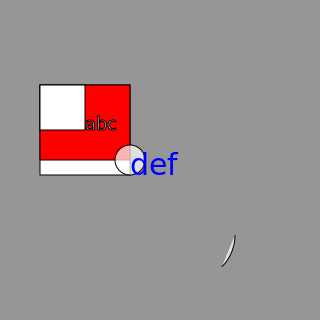

In [5]:
newSketch(200, 200, False, pad=10, scale=1.5, xoff=-20, yoff=-50); background(150)
rect(0, 0, 60, 60)
with context(): # all style changes here will be reverted on exiting the context
    fill(255, 0, 0)
    rect(0, 0, 60, 50)
rect(0, 0, 30, 30)
fill(255, 180); ellipse(60, 50, 20)
textSize(12); text("abc", 30, 30)
arc(100, 100, 30, 0, pi/4)
with context():
    fill(0, 0, 255); noStroke(); textSize(20)
    text("def", 60, 60)
img()

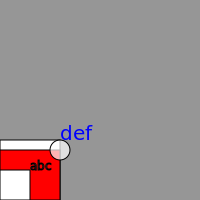

In [6]:
newSketch(200, 200); background(150)
rect(0, 0, 60, 60)
with context(): # all style changes here will be reverted on exiting the context
    fill(255, 0, 0)
    rect(0, 0, 60, 50)
rect(0, 0, 30, 30)
fill(255, 180); ellipse(60, 50, 20)
textSize(12); text("abc", 30, 30)
with context():
    fill(0, 0, 255); noStroke(); textSize(20)
    text("def", 60, 60)
im = img(); im | cli.toBytes() | cli.file("../docs/images/p5.png"); im

In [7]:
#export
inf = float("inf")
class Entity(cli.BaseCli):
    def __init__(self, *args):
        """Geometry-building package.

So, within p5 module, there's sort of like a submodule that deals with geometrical data
that allows you to define things like in Geogebra, whose work I'm a huge fan of. Here's
how it works::

    # creates an IR (intermediate representation) that defines 2 points and a line connecting the 2 points
    ir = None | p5.point_raw("P1", 3, 4) | p5.point_raw("P2", 5, 8) | p5.line_2P("L1", "P1", "P2")
    # calculates the exact position of all entities within the IR, and calculate some meta information
    ir = ir | aS(p5.IR.calc) | aS(p5.IR.calcMeta)
    # create a p5 sketch, setup some initial variables
    p5.newSketch(400, 400); p5.background(155); p5.textSize(16)
    # creates an image from the IR
    IR.display(ir); im = p5.img()

The idea is, you can define the sketch however you like, with relationships between them (like how
a line is made of 2 points, or construct a circle with a specified center that passes through another
point). After that, you'll receive the IR, which is a simple object that can be turned into a json
that can be understood by other parts of your system.

After you got the IR, you can calculate the precise location of every element with :meth:`IR.calc`.
Then you can calculate extra metadata about the viewing frame to display it on with :meth:`IR.calcMeta`.
Finally, you can do :meth:`IR.display`
"""
        self.irL = type(self).init(*args)
    def __ror__(self, ir): ir = ir or {"def": {}, "meta": None}; ir["def"][self.irL[0]] = self.irL; return ir
    @classmethod
    def dependsOn(cls,ir,name:str) -> List[str]:
        """Should return List[name]]"""
        return []
    @classmethod
    def calc(cls,ir,name:str) -> List[float]: return NotImplemented
    @classmethod
    def bounds(cls,ir,name:str) -> List[float]: return [inf,-inf,inf,-inf] # calculates the bounds of the object: xmin, xmax, ymin, ymax
    @classmethod
    def display(cls,ir,name:str,meta): pass # meta = [transXY (lambda), scale: (lambda)]

In [8]:
#export
class Point(Entity): # final coordinate format: [x, y]
    @classmethod
    def display(cls,ir,name):
        o = ir["def"][name]; props = {**{"stroke": "#ff0000"},**(o[3] or {})}
        if props.get("display", None) == "none": return
        if "stroke" in props: stroke(props["stroke"])
        x,y = ir["meta"][0](*o[4]); fill(255); ellipse(x,y,3); text(props.get("name", name),x+6,y+6)
    @classmethod
    def bounds(cls,ir,name): x,y = ir["def"][name][4]; return [x,x,y,y]
def point_rnd(name:str, props=None):
    """Creates a point with a random location. See also: :class:`Entity`

:param name: name of point"""
    return point_raw(name, *np.random.randn(2), props)
class point_raw(Point):
    def __init__(self,name:str,x:float,y:float,props=None):
        """Creates a point from actual raw coordinates. See also: :class:`Entity`

:param name: name of point
:param x: position on x axis
:param y: position on y axis"""
        self.irL = [name, "point_raw", [x, y], props, []]
    @classmethod
    def dependsOn(cls,ir,name:str): return []
    @classmethod
    def calc(cls,ir,name:str): return ir["def"][name][2]
class point_sym(Point):
    def __init__(self,name:str,p1:str,pm:str,props=None):
        """Creates a point which is symmetric to point "p1" around point "pm".
Basically, "pm" is the midpoint of "p1" and the new point. See also: :class:`Entity`

:param name: name of point
:param p1: name of the other point
:param pm: name of the middle point"""
        self.irL = [name, "point_sym", [p1,pm], props, []] # point 1 and point mid
    @classmethod
    def dependsOn(cls,ir,name:str): return ir["def"][name][2]
    @classmethod
    def calc(cls,ir,name:str): p1,pm = ir["def"][name][2]; x1,y1 = ir["def"][p1][4]; xm,ym = ir["def"][pm][4]; dx = xm-x1; dy = ym-y1; return [x1+2*dx, y1+2*dy]
class point_L(Point):
    def __init__(self,name:str,l1:str,f:float,props=None):
        """Creates a point on a line at a particular fraction.
If "f" is 0.1, it'll be close to the first point of the line,
if "f" is 0.9, it'll be close to the second point of the line.

:param name: name of point
:param l1: name of line that the point is on
:param f: fraction between the 2 points on the line. Can be any number, not just from 0 to 1"""
        self.irL = [name, "point_L", [l1,f], props, []]
    @classmethod
    def dependsOn(cls,ir,name:str): return ir["def"][name][2][:1]
    @classmethod
    def calc(cls,ir,name:str): l1,f = ir["def"][name][2]; x1,y1,x2,y2 = ir["def"][l1][4]; return x1*(1-f)+x2*f, y1*(1-f)+y2*f
def triangle(p1:str,p2:str,p3:str,props1=None,props2=None,props3=None):
    """Creates 3 random points that looks like a reasonable triangle,
with flat base and pointy upward tip.

:param p1: name of first point
:param props1: optional properties of the first point"""
    while True:
        ya, yb = np.random.randn(2)
        if ya < yb: ya, yb = yb, ya
        x2, x3 = np.random.randn(2)
        if x2 > x3: x2,x3 = x3,x2
        x1 = x2+random.random()*(x3-x2)
        if 0.3 < abs(ya-yb)/abs(x3-x2) < 3: break
    return point_raw(p1,x1,ya,props1) | point_raw(p2,x2,yb,props2) | point_raw(p3,x3,yb,props3)

In [9]:
#export
class Line(Entity): # final coordinate format: [x1, y1, x2, y2]
    @classmethod
    def display(cls,ir,name):
        o = ir["def"][name]; props = {**{"stroke": "#0000ff"},**(o[3] or {})}
        if props is not None and props.get("display", None) == "none": return
        if "stroke" in props: stroke(props["stroke"])
        f = ir["meta"][0]; x1,y1,x2,y2 = o[4] | cli.batched(2) | ~cli.apply(f) | cli.joinSt(); line(x1,y1,x2,y2); text(props.get("name", name),(x1+x2)/2+6, (y1+y2)/2+6)
    @classmethod
    def bounds(cls,ir,name): x1,y1,x2,y2 = ir["def"][name][4]; return [min(x1,x2), max(x1,x2), min(y1,y2), max(y1,y2)]
class line_P(Line):
    def __init__(self,name:str,p1:str,angle:float,l:float,f:float=0.5,props=None):
        """Creates a line that passes through a point, with an angle from the x axis, a specific length and a specific point fraction.

:param name: name of line
:param p1: name of point
:param angle: angle with respect to the x axis
:param l: length of the line
:param f: fraction of the line the point is located at"""
        self.irL = [name, "line_P", [p1,angle,l,f], props, []]
    @classmethod
    def dependsOn(cls,ir,name:str): return ir["def"][name][2][:1]
    @classmethod
    def calc(cls,ir,name:str): p1,angle,l,f = ir["def"][name][2]; x,y = ir["def"][p1][4]; dx = math.cos(angle)*l; dy = math.sin(angle)*l; return [x-dx*f, y-dy*f, x+dx*(1-f), y+dy*(1-f)]#return [x-dx*(1-f), y-dy*(1-f), x+dx*f, y+dy*f]
class line_2P(Line):
    def __init__(self,name:str,p1:str,p2:str,prevF:float=0,nextF:float=0,props=None):
        """Creates a line that connects 2 points together. See also: :class:`Entity`

:param name: name of line
:param p1: name of first point
:param p2: name of second point
:param prevF: "previous fraction". How much should the line extend past
    the first point as a fraction of the distance between p1 and p2
:param nextF: "next fraction". How much should the line extend past
    the second point as a fraction of the distance between p1 and p2
"""
        self.irL = [name, "line_2P", [p1, p2, prevF, nextF], props, []]
    @classmethod
    def dependsOn(cls,ir,name:str): return ir["def"][name][2][:2]
    @classmethod
    def calc(cls,ir,name:str):
        p1, p2, prevF, nextF = ir["def"][name][2]; x1, y1 = ir["def"][p1][4]; x2, y2 = ir["def"][p2][4]; dx = x2 - x1; dy = y2 - y1
        return [x1-dx*prevF,y1-dy*prevF,x2+dx*nextF,y2+dy*nextF]
class line_2PL(Line):
    def __init__(self,name:str,p1:str,p2:str,l:float,props=None):
        """Creates a line that connects 2 points together that starts at the first
point and has specific length. If extended indefinitely, it will pass through the
second point, but in its normal state, it doesn't have to pass through or can
overshoot the second point. Useful for creating rays. See also: :class:`Entity`

:param name: name of the line
:param p1: name of first point
:param p2: name of second point
:param l: length of line
"""
        self.irL = [name, "line_2PL", [p2,p2,l], props, []]
    @classmethod
    def dependsOn(cls,ir,name:str): return ir["def"][name][2][:2]
    @classmethod
    def calc(cls,ir,name:str): pass

In [10]:
#export
class Circle(Entity): # final coordinate format: [x, y, r]
    @classmethod
    def display(cls,ir,name):
        o = ir["def"][name]; props = {**{"stroke": "#000000"},**(o[3] or {})}
        if props is not None and props.get("display", None) == "none": return
        if "stroke" in props: stroke(props["stroke"])
        x,y,r = o[4]; x,y = ir["meta"][0](x,y); r *= ir["meta"][1]; ellipse(x,y,r*2); text(props.get("name", name),x+r*1.1,y)
    @classmethod
    def bounds(cls,ir,name): x,y,r = ir["def"][name][4]; return [x-r,x+r,y-r,y+r]
class circle_PR(Circle): # circle from center point and radius
    def __init__(self,name:str,p1:str,radius:float,props=None):
        """Creates a circle from a center point and a radius. See also: :class:`Entity`

:param name: name of circle
:param p1: name of the center point
:param radius: radius of the circle"""
        self.irL = [name, "circle_PR", [p1, radius], props, []]
    @classmethod
    def dependsOn(cls,ir,name:str): return [ir["def"][name][2][0]]
    @classmethod
    def calc(cls,ir,name:str): o = ir["def"][name][2]; return [*ir["def"][o[0]][4], o[1]]
class circle_2P(Circle): # circle that has center pc and passes through point p2
    def __init__(self,name:str,pc:str,p2:str,props=None):
        """Creates a circle from a center point that passes through another
point. See also: :class:`Entity`

:param name: name of circle
:param pc: name of the center point
:param p2: name of the second point that the circle passes through"""
        self.irL = [name, "circle_2P", [pc, p2], props, []]
    @classmethod
    def dependsOn(cls,ir,name:str): return ir["def"][name][2]
    @classmethod
    def calc(cls,ir,name:str): pc, p2 = ir["def"][name][2]; xc, yc = ir["def"][pc][4]; x2, y2 = ir["def"][p2][4]; dx = x2-xc; dy = y2-yc; return [xc,yc,math.sqrt(dx*dx+dy*dy)]

In [11]:
#export
class grid(Entity):
    def __init__(self, name="grid-0", props=None):
        """Adds a grid to the plot. See also: :class:`Entity`"""
        self.irL = ["grid-0", "grid", [], props, []]
    @classmethod
    def display(cls,ir,name):
        if not ir["meta"]: raise Exception(f"Please calculate the positions of everything and metadata first, before trying to display an IR that has a grid")
        o = ir["def"][name]; meta = ir["meta"]; w,h = meta[2]; [dx,dy],[cx,cy],[x,y] = meta[4:7]; f,s = meta[:2]
        scale = int(math.log10(max(dx,dy)/1.3)); fac = 10**scale # 10^scale for the grid's spacing
        ccx = max((w/h)/(dx/dy), 1); ccy = max((h/w)/(dy/dx), 1) # correction factors
        xticks = range(math.ceil((cx-ccx*dx*0.8)/fac), math.ceil((cx+ccx*dx*0.8)/fac)) | cli.apply(cli.op()/fac) | cli.deref()
        yticks = range(math.ceil((cy-ccy*dy*0.8)/fac), math.ceil((cy+ccy*dy*0.8)/fac)) | cli.apply(cli.op()/fac) | cli.deref()
        with context():
            stroke(100)
            for x in xticks: line(*f(x, cy-ccy*dy*1.2), *f(x, cy+ccy*dy*1.2))
            for y in yticks: line(*f(cx-ccx*dx*1.2, y), *f(cx+ccx*dx*1.2, y))

In [12]:
#export
def round2(x): return int(x) if int(x) == x else x
class axes(Entity):
    def __init__(self, name="axes-0", props=None):
        """Adds xy axis to the plot. See also: :class:`Entity`"""
        self.irL = ["axes-0", "axes", [], props, []]
    @classmethod
    def display(cls,ir,name):
        if not ir["meta"]: raise Exception(f"Please calculate the positions of everything and metadata first, before trying to display an IR that has a grid")
        o = ir["def"][name]; meta = ir["meta"]; w,h = meta[2]; [dx,dy],[cx,cy],[x,y] = meta[4:7]; f,s = meta[:2]
        scale = int(math.log10(max(dx,dy)/1.3)); fac = 10**scale # 10^scale for the grid's spacing
        ccx = max((w/h)/(dx/dy), 1); ccy = max((h/w)/(dy/dx), 1) # correction factors
        line(*f(0, cy-ccy*dy*1.2), *f(0, cy+ccy*dy*1.2))
        line(*f(cx-ccx*dx*1.2, 0), *f(cx+ccx*dx*1.2, 0))
        xticks = range(math.ceil((cx-ccx*dx*0.8)/fac), math.ceil((cx+ccx*dx*0.8)/fac)) | cli.apply(cli.op()/fac) | cli.deref()
        yticks = range(math.ceil((cy-ccy*dy*0.8)/fac), math.ceil((cy+ccy*dy*0.8)/fac)) | cli.apply(cli.op()/fac) | cli.filt("x") | cli.deref()
        with context():
            for x in xticks: text(f"{round2(x)}", *f(x, 0) | (cli.op()-5) + (cli.op()+10))
            for y in yticks: text(f"{round2(y)}", *f(0, y) | (cli.op()+10) + (cli.op()-5))

In [13]:
#export
def vlen(dx,dy): return math.sqrt(dx*dx+dy*dy) # vector length
entities = [point_raw, point_sym, point_L, line_P, line_2P, line_2PL, circle_PR, circle_2P, grid, axes]; entitiesD = entities | cli.apply(lambda x: [x.__name__, x]) | cli.toDict()
class IR:
    """Intermediate representation of a whole graph"""
    @staticmethod
    def dep(ir) -> Iterator[str]: # figures out the dependency graph, returns elements to calculate position of
        d = defaultdict(lambda: []); a = ir["def"].values() | cli.cut(0, 1) | cli.lookup(entitiesD, 1) | ~cli.apply(lambda name,cls: [name,cls.dependsOn(ir,name)]) | ~cli.apply(lambda x,y:[x,y,len(y)]) | cli.deref()
        for x,y,z in a:
            for p in y: d[p].append(x)
        freqs = a | cli.cut(0, 2) | cli.toDict(); stack = deque(a | cli.cut(0, 2) | ~cli.filt("x", 1) | cli.cut(0) | cli.deref())
        while len(stack) > 0:
            c = stack.popleft(); yield c
            for child in d[c]:
                freqs[child] -= 1
                if freqs[child] == 0: stack.append(child)
    @staticmethod
    def calc(ir): # calculates position of every element and write results back to IR
        for e in IR.dep(ir): ir["def"][e][4] = entitiesD[ir["def"][e][1]].calc(ir,e)
        return ir
    @staticmethod
    def bounds(ir): return ir["def"].values() | cli.apply(lambda e: entitiesD[e[1]].bounds(ir, e[0])) | cli.transpose() | cli.toMin() + cli.toMax() + cli.toMin() + cli.toMax() | cli.deref()
    @staticmethod
    def calcMeta(ir,w=400,h=400): # calculates meta transformation functions
        bounds = IR.bounds(ir)
        a, b, c, d = bounds; cx = (a+b)/2; cy = (c+d)/2; dx = b-a; dy = d-c
        sx = w/dx; sy = h/dy; s = min(sx, sy)/1.2; f1 = lambda x,y: [(x-cx)*s+w/2, (y-cy)*s+h/2]
        ir["meta"] = [f1, s, [w, h], [sx, sy], [dx, dy], [cx, cy], [a, c]]; return ir
    @staticmethod
    def display(ir,w=400,h=400): # constructs an image of the IR
        if not ir["meta"]: IR.calcMeta(ir,w,h)
        # draw order: circle -> line -> point, because transparent fills are not really a thing in this knock up version of p5
        for e in ir["def"].values() | cli.filt(cli.op().split("_")[0] == "grid", 1): entitiesD[e[1]].display(ir,e[0])
        for e in ir["def"].values() | cli.filt(cli.op().split("_")[0] == "axes", 1): entitiesD[e[1]].display(ir,e[0])
        for e in ir["def"].values() | cli.filt(cli.op().split("_")[0] == "circle", 1) | ~cli.sortF(cli.op()[4][2]): entitiesD[e[1]].display(ir,e[0])
        for e in ir["def"].values() | cli.filt(cli.op().split("_")[0] == "line",   1): entitiesD[e[1]].display(ir,e[0])
        for e in ir["def"].values() | cli.filt(cli.op().split("_")[0] == "point",  1): entitiesD[e[1]].display(ir,e[0])
    @staticmethod
    def dist_2P(ir, o1:str, o2:str):
        """Calculates distance between 2 objects given their names"""
        o1 = ir["def"][o1]; o2 = ir["def"][o2]; x1,y1 = o1[4]; x2,y2 = o2[4]; return vlen(x2-x1, y2-y1)
    @staticmethod
    def length_L(ir, line:str):
        """Calculates the length of a specific line"""
        x1,y1,x2,y2 = ir["def"][line][4]; return vlen(x2-x1, y2-y1)
    @staticmethod
    def angle_2L(ir, l1:str, l2:str) -> "``radians``":
        """Calculates the angle between 2 lines"""
        x1,y1,x2,y2 = ir["def"][l1][4]; x3,y3,x4,y4 = ir["def"][l2][4]
        dx1 = x2-x1; dx2 = x4-x3; dy1 = y2-y1; dy2 = y4-y3
        return math.acos((dx1*dx2+dy1*dy2)/vlen(dx1,dy1)/vlen(dx2,dy2))

In [14]:
%%time
ir = None | point_raw("P0", 0, 0) | point_raw("P1", 3, 4) | point_raw("P2", 5, 8) | point_raw("P3", 5, 6) | line_2P("L1", "P1", "P2") | line_2P("L2", "P1", "P3") | point_sym("P4", "P2", "P3") | circle_PR("C1", "P1", 1) | circle_2P("C2", "P3", "P1") | cli.aS(IR.calc) | cli.aS(IR.calcMeta, 400, 400) | grid() | axes(); ir

CPU times: user 966 µs, sys: 201 µs, total: 1.17 ms
Wall time: 1.08 ms


{'def': {'P0': ['P0', 'point_raw', [0, 0], None, [0, 0]],
  'P1': ['P1', 'point_raw', [3, 4], None, [3, 4]],
  'P2': ['P2', 'point_raw', [5, 8], None, [5, 8]],
  'P3': ['P3', 'point_raw', [5, 6], None, [5, 6]],
  'L1': ['L1', 'line_2P', ['P1', 'P2', 0, 0], None, [3, 4, 5, 8]],
  'L2': ['L2', 'line_2P', ['P1', 'P3', 0, 0], None, [3, 4, 5, 6]],
  'P4': ['P4', 'point_sym', ['P2', 'P3'], None, [5, 4]],
  'C1': ['C1', 'circle_PR', ['P1', 1], None, [3, 4, 1]],
  'C2': ['C2', 'circle_2P', ['P3', 'P1'], None, [5, 6, 2.8284271247461903]],
  'grid-0': ['grid-0', 'grid', [], None, []],
  'axes-0': ['axes-0', 'axes', [], None, []]},
 'meta': [<function __main__.IR.calcMeta.<locals>.<lambda>(x, y)>,
  37.75681994349774,
  [400, 400],
  [51.09583235891318, 45.30818393219729],
  [7.82842712474619, 8.82842712474619],
  [3.914213562373095, 4.414213562373095],
  [0, 0]]}

CPU times: user 39.3 ms, sys: 1.06 ms, total: 40.3 ms
Wall time: 86.2 ms


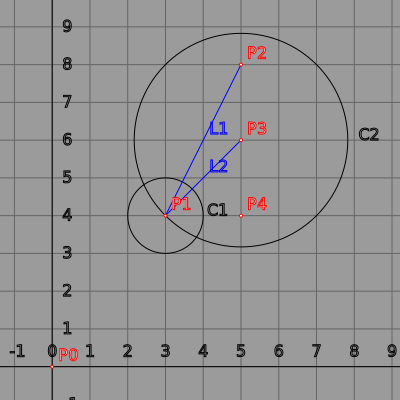

In [15]:
%%time
newSketch(400, 400); background(155); textSize(16); noFill(); IR.display(ir); img()

In [16]:
assert int(IR.angle_2L(ir, "L1", "L2")/3.14159*180) == 18
assert IR.dist_2P(ir, "P2", "P3") == 2
assert int(IR.length_L(ir, "L1")) == 4

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 35.8 ms


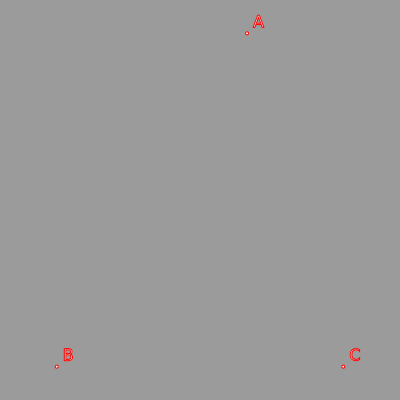

In [17]:
%%time
newSketch(400, 400); background(155); textSize(16); noFill(); IR.display(None | triangle(*"ABC") | cli.aS(IR.calc)); img()

In [94]:
#export
k1lib.settings.add("p5", k1lib.Settings()
    .add("funcs", ["arc", "ellipse", "circle", "line", "point", "quad", "rect", "square", "triangle", "text",
                   "color", "fill", "noFill", "stroke", "noStroke", "background"], "p5 functions to syntactically replace in instance mode")
    .add("symbols", ["mouseX", "mouseY"], "symbols to syntactically replace in instance mode"),
"p5 module settings");
class Sketch(cli.BaseCli):
    def __init__(self, f:str, width=500, height=500):
        """Creates a real p5js sketch, but make it convenient.
Example::

    "some data" | p5.Sketch('''
        function setup() {
            background(200);
        }
        function draw() {
            background(200);
            text(data, 20, 20);
            ellipse(mouseX, mouseY, 20, 20);
        }
    ''')

:param f: the js string to inject into the sketch
:param width: width of the sketch
:param height: height of the sketch"""
        self.width = width; self.height = height
        if "function setup() {" not in f: raise Exception("Function setup() not found, please start the function with `function setup() {`")
        if "function draw() {" not in f:  raise Exception("Function draw() not found, please start the function with `function draw() {`")
        self.f = f.replace("function setup() {", f"function setup() {{ p.createCanvas({width}, {height}); ")
    def __ror__(self, it):
        pre = cli.init._jsDAuto(); f = self.f
        for sym in k1lib.settings.p5.funcs:   f = f.replace(f"{sym}(", f"p.{sym}(")
        for sym in k1lib.settings.p5.symbols: f = f.replace(f"{sym}", f"p.{sym}")
        f = f.replace(".p.", ".")
        return k1lib.viz.Html(f"""
<div id="{pre}_sketch" style="width: {self.width}px; height: {self.height}px"></div>
<div id="{pre}_errors">&nbsp;</div>
<script src="https://cdnjs.cloudflare.com/ajax/libs/p5.js/1.9.3/p5.min.js" integrity="sha512-0zGLOFv/+OQ6YfVCSGDQWhrDRx0ONmBqWvs3gI4olm8i6xtKoG1FhEnB4eTaWCVnojyfUDgE8Izeln+mAJAkFA==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
<script>
    new p5(p => {{
        const data = {json.dumps(it)};{f}
        p.setup = setup;
        p.draw = draw;
    }}, document.querySelector("#{pre}_sketch"));
</script>
""")

In [95]:
"abc" | Sketch(f"""
function setup() {{
    background(200);
}}
function draw() {{
    background(200);
    text(data, 20, 20);
    ellipse(mouseX, mouseY, 20, 20);
}}""")

'\n<div id="_jsD_245_1714206943_3599_sketch" style="width: 500px; height: 500px"></div>\n<div id="_jsD_245_1714206943_3599_errors">&nbsp;</div>\n<script src="https://cdnjs.cloudflare.com/ajax/libs/p5.js/1.9.3/p5.min.js" integrity="sha512-0zGLOFv/+OQ6YfVCSGDQWhrDRx0ONmBqWvs3gI4olm8i6xtKoG1FhEnB4eTaWCVnojyfUDgE8Izeln+mAJAkFA==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>\n<script>\n    new p5(p => {\n        const data = "abc";\nfunction setup() { p.createCanvas(500, 500); \n    p.background(200);\n}\nfunction draw() {\n    p.background(200);\n    p.text(data, 20, 20);\n    p.ellipse(p.mouseX, p.mouseY, 20, 20);\n}\n        p.setup = setup;\n        p.draw = draw;\n    }, document.querySelector("#_jsD_245_1714206943_3599_sketch"));\n</script>\n'

In [126]:
#export
class Anim(cli.BaseCli):
    def __init__(self, width=500, height=500):
        """Creates a quick animation that internally runs on p5js.
Why not just use matplotlib or smth? Their performance is quite
terrible, and sometimes I just want a simple way to display
animations. Example::

    [[0,    "ellipse(200,300,20,20);text('abc',20,20);"],
     [0.03, "ellipse(204,299,19,19);text('abc',22,23);"]] | p5.Anim()

The left column is the time in seconds to draw the frame, and the right column is the
code to execute on that frame. Pretty simple really."""
        self.width = width;
        self.height = height
    def __ror__(self, it):
        pre = cli.init._jsDAuto(); it = it | cli.sort() | cli.deref(); maxT = it[-1][0]
        timeouts = it | ~cli.apply(lambda x,y: f"setTimeout(() => {{ background(200);text('Time: {x}s, {round(x/maxT*100,2)}%',20,{self.height-20});{y} }}, {x*1000});") | cli.join("\n")
        return None | Sketch(f"""
{pre}_refresh = () => {{ {timeouts}; }}; {pre}_refresh();
setInterval({pre}_refresh, {(maxT+1)*1000});
function setup() {{ background(200); }}
function draw() {{ }}
""", self.width, self.height)

In [127]:
[[0,    "ellipse(200,300,20,20);text('abc',20,20);"],
 [0.03, "ellipse(204,299,19,19);text('abc',22,23);"]]\
| Anim()

'\n<div id="_jsD_245_1714206943_3624_sketch" style="width: 500px; height: 500px"></div>\n<div id="_jsD_245_1714206943_3624_errors">&nbsp;</div>\n<script src="https://cdnjs.cloudflare.com/ajax/libs/p5.js/1.9.3/p5.min.js" integrity="sha512-0zGLOFv/+OQ6YfVCSGDQWhrDRx0ONmBqWvs3gI4olm8i6xtKoG1FhEnB4eTaWCVnojyfUDgE8Izeln+mAJAkFA==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>\n<script>\n    new p5(p => {\n        const data = null;\n_jsD_245_1714206943_3623_refresh = () => { setTimeout(() => { p.background(200);p.text(\'Time: 0s, 0.0%\',20,480);p.ellipse(200,300,20,20);p.text(\'abc\',20,20); }, 0);\nsetTimeout(() => { p.background(200);p.text(\'Time: 0.03s, 100.0%\',20,480);p.ellipse(204,299,19,19);p.text(\'abc\',22,23); }, 30.0);; }; _jsD_245_1714206943_3623_refresh();\nsetInterval(_jsD_245_1714206943_3623_refresh, 1030.0);\nfunction setup() { p.createCanvas(500, 500);  p.background(200); }\nfunction draw() { }\n\n        p.setup = setup;\n        p.draw = draw;\n    }, document.querySelector("#_jsD_245_1714206943_3624_sketch"));\n</script>\n'

In [129]:
!../export.py p5 --upload=True

2024-04-27 05:52:11,589	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.17:6379...
2024-04-27 05:52:11,640	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
./export started up - /home/kelvin/anaconda3/envs/ray2/bin/python3
----- exportAll
15959   0   61%   
10371   1   39%   
Found existing installation: k1lib 1.7
Uninstalling k1lib-1.7:
  Successfully uninstalled k1lib-1.7
Looking in indexes: https://pypi.org/simple, http://mint-2.l:3141/
Processing /home/kelvin/repos/labs/k1lib
  Preparing metadata (setup.py) ... done
  Created wheel for k1lib: filename=k1lib-1.7-py3-none-any.whl size=5098729 sha256=af1a22071e18d839630f9209e8333365c157803c420a1b90338bbfa822441c4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-zhq4gmm_/wheels/fb/be/7d/105fb38c560564c6556311fd52f77295b9fec253e4ba7cfd75
Successfully built k1lib


In [128]:
!../export.py p5

2024-04-27 05:51:20,476	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.17:6379...
2024-04-27 05:51:20,488	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
./export started up - /home/kelvin/anaconda3/envs/ray2/bin/python3
----- exportAll
15959   0   61%   
10371   1   39%   
Found existing installation: k1lib 1.7
Uninstalling k1lib-1.7:
  Successfully uninstalled k1lib-1.7
Looking in indexes: https://pypi.org/simple, http://mint-2.l:3141/
Processing /home/kelvin/repos/labs/k1lib
  Preparing metadata (setup.py) ... done
  Created wheel for k1lib: filename=k1lib-1.7-py3-none-any.whl size=5098729 sha256=d8db18339d0378465c7a584301e2fe73da55b0dd946e5f27be428e22060ba7ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-1zr9dqr6/wheels/fb/be/7d/105fb38c560564c6556311fd52f77295b9fec253e4ba7cfd75
Successfully built k1lib
